# Autometic Judgment Analysis

In [105]:
import pandas as pd
import numpy as np
import requests
import tarfile
import json
import gzip
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
nist_qrel_file = 'qrels/2023.qrels.pass.withDupes.txt'
gpt4_qrel_file = 'qrels/2023.qrels.pass.gpt4.txt'
dl_2023_queries = "dl-2023-queries.tsv"

## Loading Judgments

In [9]:
# loading judged queries
nist_qrels = pd.read_csv(nist_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
# loading judged queries - GPT-4
gpt4_qrels = pd.read_csv(gpt4_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])

In [73]:
nist_qrels.groupby('qid')['qid'].agg('count')

qid
2001010    223
2001459    374
2001575    191
2002075    270
2002168    483
          ... 
3100825    173
3100833    224
3100909    337
3100918    217
3100922    190
Name: qid, Length: 82, dtype: int64

In [8]:
queries_judged = set(nist_qrels['qid'])
docids = set(nist_qrels['docid'])

In [74]:
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [27]:
queries = pd.read_csv(dl_2023_queries, sep='\t', header=None, names=['qid', 'qtext'])
queries.head()

,qid,qtext
0,2000138,How does the process of digestion and metaboli...
1,2000438,apatite definition
2,2000727,calculate salary from basic pay
3,2000882,cerebellar disease definition
4,2001010,cost comparison of funerals in australia


## Loading Documents

In [10]:
def read_bundles(bundlenum):
     with gzip.open(f'msmarco_v2_passage/msmarco_passage_{bundlenum}.gz','r') as fpassage:
          for passage in fpassage:
            json_passage = json.loads(passage.decode('utf8'))
            if json_passage['pid'] in docids:
                docid_to_passage[json_passage['pid']] = json_passage['passage']

In [11]:
# read TREC passagess
docid_to_passage = {}

for bundlenum in tqdm(range(0, 70)):
    if bundlenum < 10:
        bundlenum = f'0{str(bundlenum)}'
    read_bundles(bundlenum=bundlenum)

100%|██████████| 70/70 [09:49<00:00,  8.43s/it]


In [84]:
more_relevant_by_nist_qids = set()
more_relevant_by_nist_docids = set()

more_relevant_by_llm_qids = set()
more_relevant_by_llm_docids = set()

equal_qids = set()
equal_docids = set()

In [85]:
for nist_qrel, llm_qrel in zip(nist_qrels.itertuples(index=True), gpt4_qrels.itertuples(index=True)):
    if nist_qrel.qid == llm_qrel.qid:
        if nist_qrel.qid in (t5_queries_judged + gpt4_queries_judged):
            if nist_qrel.docid == llm_qrel.docid:
                if nist_qrel.rel != llm_qrel.rel:
                    # llm gives lower score
                    if nist_qrel.rel > llm_qrel.rel:
                        more_relevant_by_nist_qids.add(nist_qrel.qid)
                        more_relevant_by_nist_docids.add(nist_qrel.docid)
                    # llm gives higher score
                    elif nist_qrel.rel < llm_qrel.rel:
                        more_relevant_by_llm_qids.add(nist_qrel.qid)
                        more_relevant_by_llm_docids.add(nist_qrel.docid)
                else:
                    equal_qids.add(nist_qrel.qid)
                    equal_docids.add(nist_qrel.docid)
            else:
                print("No equal docid.")
    else:
        print("Not equal qid.")

In [86]:
len(more_relevant_by_llm_docids), len(more_relevant_by_nist_docids)

(2623, 943)

In [87]:
XX = (more_relevant_by_llm_docids - more_relevant_by_nist_docids) - equal_docids
YY = (more_relevant_by_nist_docids - more_relevant_by_llm_docids) - equal_docids

In [88]:
len(XX), len(YY)

(2526, 855)

In [89]:
docid_sum_len = 0
for eachitem in YY:
        doc_len = get_doc_length(docid_to_passage[eachitem])
        docid_sum_len += doc_len
print(docid_sum_len / len(XX))

17.711401425178146


In [90]:
docid_sum_len = 0
for eachitem in XX:
        doc_len = get_doc_length(docid_to_passage[eachitem])
        docid_sum_len += doc_len
print(docid_sum_len / len(XX))

51.486144101346


In [68]:
len(more_relevant_by_llm_qids), len(more_relevant_by_nist_qids)

(81, 81)

- for all queries made the wrong prediction

In [69]:
len(equal_qids)

82

1. Getting average document length

In [17]:
def get_query_length(query_text):
    query_len = len(query_text.split(' '))
    if query_len >= 10:
        # long query == 1
        query_len_type = 1
    else:
        # short query == 0
        query_len_type = 0
    return query_len_type, query_len

In [16]:
def get_doc_length(passage):
    passage_len = len(passage.split(' '))
    return passage_len

In [18]:
passages_len = []
for eachline in nist_qrels.itertuples(index=True):
        doc_len = get_doc_length(docid_to_passage[eachline.docid])
        passages_len.append(doc_len)

In [26]:
len(passages_len)

22327

In [21]:
np.average(passages_len)

145.6498857885072

In [27]:
c = 0
for passage_len in passages_len:
    if passage_len > 50:
        c+=1
print(c)

11577


## Bland Altman Plot

Bias (Mean Difference): -0.28


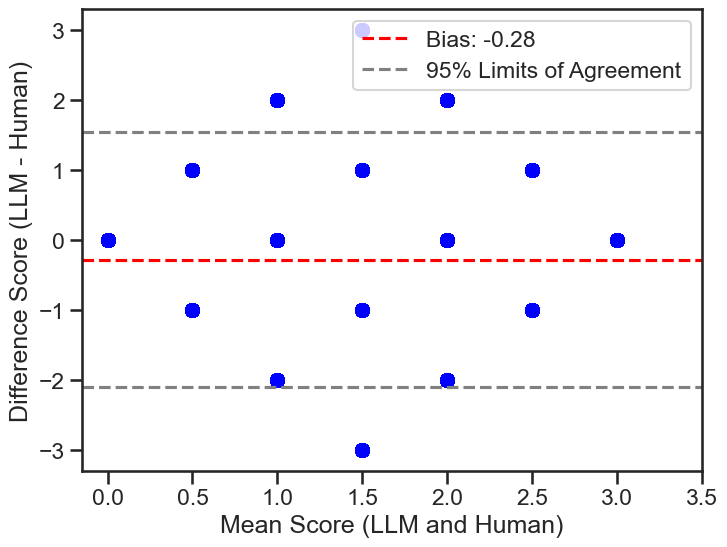

In [116]:
# Example categorical relevance scores (human and LLM)
human_scores = nist_qrels['rel']
llm_scores = gpt4_qrels['rel']

# Calculate the differences between human and LLM scores
diff_scores = human_scores - llm_scores

# Calculate the bias (mean difference)
bias = np.mean(diff_scores)

# Print the bias
print(f'Bias (Mean Difference): {bias:.2f}')

# Bland-Altman Plot function
def bland_altman_plot(data1, data2):
    mean_scores = np.mean([data1, data2], axis=0)
    diff_scores = data1 - data2
    mean_diff = np.mean(diff_scores)
    std_diff = np.std(diff_scores)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_scores, diff_scores, color='blue', alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Bias: {mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='95% Limits of Agreement')
    plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--')
    # plt.title('Bland-Altman Plot for Categorical Scores')
    plt.xlabel('Mean Score (LLM and Human)')
    plt.ylabel('Difference Score (LLM - Human)')
    plt.yticks(np.arange(-3, 4, step=1))
    plt.xticks(np.arange(0, 4, step=0.5))
    plt.legend()
    plt.savefig("figs/bland_altman_plot_scores.pdf", bbox_inches="tight")

# Run the Bland-Altman Plot
bland_altman_plot(human_scores, llm_scores)
